# Tuning The Model

In [1]:
import glob, os
import numpy as np
from matplotlib import pyplot as plt
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream,interval

We define necessary functions:

In [3]:
def get_stream_from_midi_without_drums(midi_path):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    
    for i in range(len(mf.tracks)):
        mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)

def stream_to_array_of_pitches_strings (stream):
    result = []
    for element in stream.flat.notes:
        stringRepresentationOfElement = ''
        if isinstance(element, note.Note):
            stringRepresentationOfElement = element.pitch.ps
        else: # it's a chord
            stringRepresentationOfElement = [note.pitch.ps for note in element.notes][0]
            #stringRepresentationOfElement = ' '.join(listOfNotesWithOctaves)
        result.append(stringRepresentationOfElement)
    return result

def from_midi_to_array_of_pitches (midi_path):
    return stream_to_array_of_pitches_strings(get_stream_from_midi_without_drums(midi_path))

def from_pitches_to_intervals (array_of_pitches):
    intervals = []
    for i in range(1,len(array_of_pitches) - 1):
        intervals.append(array_of_pitches[i] - array_of_pitches[i-1])
    return intervals

def from_midi_to_array_of_intervals(midi_path):
    return from_pitches_to_intervals(from_midi_to_array_of_pitches(midi_path))

def get_folder_songs_intervals(folder_path):
    songs = []
    for file in glob.glob(folder_path):
        songs.append(from_midi_to_array_of_intervals(file))
    return songs

def from_array_of_intervals_to_pitches (root_pitch, intervals):
    pitches = [root_pitch]
    for interval in intervals:
        pitches.append(pitches[-1] + interval)
    return pitches

def from_pitches_to_midi (pitches, midi_path):
    streamResult = stream.Stream()
    for pitch in pitches:
            streamResult.append(note.Note(pitch))
            
    streamResult.write('midi', fp= midi_path)
    
def from_intervals_to_midi( root_pitch, intervals, midi_path):
    pitches = from_array_of_intervals_to_pitches(root_pitch, intervals)
    from_pitches_to_midi(pitches, midi_path)


In [4]:
#Test
from_intervals_to_midi(60, from_midi_to_array_of_intervals('data/examples/silent_night_easy.mid'),'test_intervals_silent_night.mid') 

We consider intervals from -100 semitones to + 100 semitones.

We create a dictionary to translate from intervals to positive positive int numbers: 

In [ ]:
songs = get_folder_songs_intervals("data/examples/*.mid")

interval_to_number = {}
number_to_interval = {}

for song in songs:
    for element in song:
        if not element in interval_to_number:
            number_to_interval[len(interval_to_number)+1] = element
            interval_to_number[element] = len(interval_to_number)+1

In [17]:
[element for element in songs[0]][:10]

[0.0, -27.0, 27.0, 0.0, -27.0, 27.0, 0.0, -27.0, 27.0, -27.0]

In [35]:
interval_to_number = {}
number_to_interval = {}

for i in range(0,100):
    interval_to_number[i] = i
    interval_to_number[-i] = 100 + i
    number_to_interval[i] = i
    number_to_interval[100+i] = -i
    

In [36]:
train_set = [[interval_to_number[element] for element in song] for song in songs]

In [39]:
def slice_sequence_examples(sequence, num_steps):
    """Slice a sequence into redundant sequences of lenght num_steps."""
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    """
    Return the examples in seq to singleton format.
    """
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

In [40]:
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 50
VOCABULARY_SIZE = 201

In [41]:
VOCABULARY_SIZE

201

In [42]:
# Slice the sequences:
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)

# Split the sequences into Xs and ys:
X, y = seq_to_singleton_format(slices)
# Convert into numpy arrays.
X = np.array(X)
y = np.array(y)

In [25]:
X.shape

(114790, 30)

We build the model:

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be 

ImportError: cannot import name 'export_saved_model' from 'tensorflow.python.keras.saving.saved_model' (C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\tensorflow\python\keras\saving\saved_model\__init__.py)

We sample:

In [53]:
from random import randint
def sample(preds):
    sorted_indexes = np.argsort(preds)[::-1]
    return sorted_indexes[randint(0,3)]

In [54]:
def sample_seq( seq, seq_length, model, number_to_note, output_seq_length ):
    if output_seq_length <= len(seq): raise Exception("output_seq_length must be higher than seq_length")
        
    output_seq = seq
    for i in range(output_seq_length - len(seq)):
        input_sequence = [seq[-seq_length:]]
        x = pad_sequences(input_sequence, maxlen = seq_length, padding="pre")
        prediction = model.predict(x)
        index = sample(prediction[0])
        output_seq.append(index)
    #[number_to_note(number) for number in output_seq]
    return output_seq

In [52]:
generated_vector = sample_seq([1], SEQ_LEN, model_interval, number_to_interval, 50)
generated_intervals = [number_to_interval[number] for number in generated_vector]


In [53]:
from_intervals_to_midi(70, generated_intervals,'generated_record_intervals_tuning.mid') 

Probando map (mean average precission): 

In [43]:
from keras.metrics import Precision
from keras.metrics import SparseTopKCategoricalAccuracy

In [44]:

HIDDEN_UNITS = 50
EPOCHS = 10
VOCABULARY_SIZE = 201

In [45]:
print('Build model...')
model_interval = Sequential()
model_interval.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=SEQ_LEN, mask_zero=True))

# LSTM part
model_interval.add(LSTM(HIDDEN_UNITS, return_sequences=True))
model_interval.add(LSTM(HIDDEN_UNITS))

# Project back to vocabulary
model_interval.add(Dense(VOCABULARY_SIZE, activation='softmax'))
#model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])#metrics=[Precision(top_k=10)])
#model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[Precision(top_k=10)])
model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[SparseTopKCategoricalAccuracy(k=10, name='sparse_top_k_categorical_accuracy')])


model_interval.summary()

Build model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 50)            10050     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 201)               10251     
Total params: 60,701
Trainable params: 60,701
Non-trainable params: 0
_________________________________________________________________


In [46]:
# checkpoint
filepath="models_checkpoints/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]

In [47]:
# Fit the model
history = model_interval.fit(X, y, validation_split = 0.1,  batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks_list)


Train on 103311 samples, validate on 11479 samples
Epoch 1/10
103311/103311 [==============================] - 164s 2ms/step - loss: 4.0554 - sparse_top_k_categorical_accuracy: 0.4050 - val_loss: 3.9107 - val_sparse_top_k_categorical_accuracy: 0.4230

Epoch 00001: saving model to models_checkpoints/weights-improvement-01-3.91.hdf5
Epoch 2/10
103311/103311 [==============================] - 158s 2ms/step - loss: 3.5839 - sparse_top_k_categorical_accuracy: 0.5458 - val_loss: 3.3368 - val_sparse_top_k_categorical_accuracy: 0.6101

Epoch 00002: saving model to models_checkpoints/weights-improvement-02-3.34.hdf5
Epoch 3/10
103311/103311 [==============================] - 159s 2ms/step - loss: 3.2419 - sparse_top_k_categorical_accuracy: 0.6322 - val_loss: 3.1857 - val_sparse_top_k_categorical_accuracy: 0.6510

Epoch 00003: saving model to models_checkpoints/weights-improvement-03-3.19.hdf5
Epoch 4/10
103311/103311 [==============================] - 158s 2ms/step - loss: 3.1133 - sparse_top_k

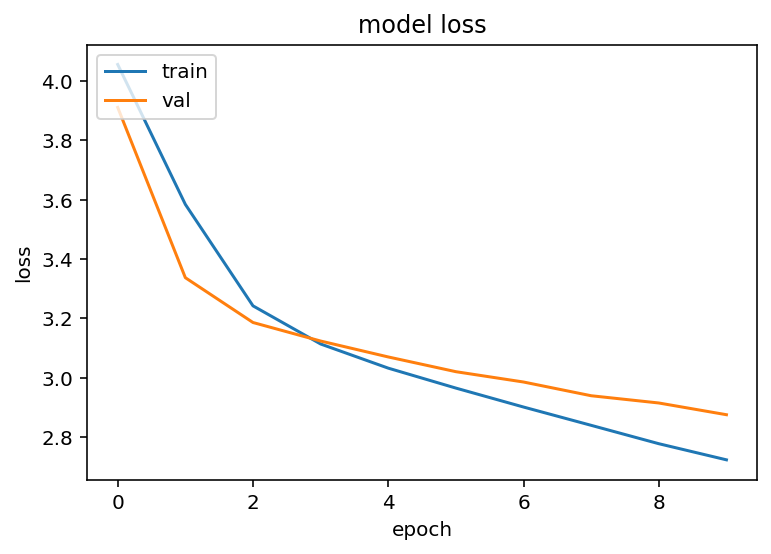

In [48]:
plt.plot(model_interval.history.history['loss'])
plt.plot(model_interval.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
from keras.losses import SparseCategoricalCrossentropy

In [50]:
SparseCategoricalCrossentropy

keras.losses.SparseCategoricalCrossentropy

In [51]:
model_interval.load_weights('models_checkpoints/weights-improvement-10-2.87.hdf5')

In [55]:
generated_vector = sample_seq([1], SEQ_LEN, model_interval, number_to_interval, 50)
generated_intervals = [number_to_interval[number] for number in generated_vector]

In [59]:
from datetime import datetime

In [60]:
datetime.now().strftime("%Y%m%d_%H%M%S")

'20210620_205756'

In [61]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 6, 20, 20, 57, 58, 363034)

In [62]:
from_intervals_to_midi(70, generated_intervals, datetime.now().strftime("%Y%m%d_%H%M%S")+'_generated_record_intervals_tuning.mid') 